In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp

from astropy.io import fits
import scipy
import pymaster as nmt

In [6]:
def get_bonus_bins(width=5, top_ell=30, l_min=2):
    bonus_bin_left, bonus_bin_right = [], []
    counter = 0
    for i in list(range(1,top_ell))[::-1]:
        counter += 1
        if i == l_min:
            bonus_bin_left.append(i)
            bonus_bin_right.append(i+width-1)
            break
        elif counter % width == 0:
            bonus_bin_left.append(i)
            bonus_bin_right.append(i+width-1)
    return bonus_bin_left[::-1], bonus_bin_right[::-1]

In [13]:
nside = 2048

def subtract_mono_di(map_in, mask_in):
    map_masked = hp.ma(map_in)
    map_masked.mask = (mask_in<1)
    mono, dipole = hp.pixelfunc.fit_dipole(map_masked)
    
    m = map_in.copy()
    npix = hp.nside2npix(nside)
    bunchsize = npix // 24
    bad = hp.UNSEEN
    for ibunch in range(npix // bunchsize):
        ipix = np.arange(ibunch * bunchsize, (ibunch + 1) * bunchsize)
        ipix = ipix[(np.isfinite(m.flat[ipix]))]
        x, y, z = hp.pix2vec(nside, ipix, False)
#         m.flat[ipix] -= dipole[0] * x
#         m.flat[ipix] -= dipole[1] * y
#         m.flat[ipix] -= dipole[2] * z
        m.flat[ipix] -= mono
        
    return m

In [14]:
# pixel_window = hp.sphtfunc.pixwin(nside, pol=False)[:len(Bl)]
pixel_window = np.load('pixwin2048.npy')

In [15]:
def get_spec(f0, f1):
#     f0, f1 = '100', '100'
    split0, split1 = '1', '2'
    lmax = 2508
    nside = 2048
    lmax_beam = 3*nside # beam needs to extend to high enough ell for NaMaster

    beam_filename = f'planck_beam/beam_probably_used_in_2015_likelihood_{f0}hm1x{f1}hm2.dat.dat'
    beam_ell, beam = np.genfromtxt(beam_filename, unpack=True) # beam file is ell, Bl
    Bl = np.zeros(lmax_beam)
    Bl[beam_ell.astype(int)] = beam

    binleft, binright = np.genfromtxt('planck_spectra/binused.dat', 
                                      unpack=True, usecols=(0,1), dtype=((int), (int)))
    bonus_left, bonus_right = get_bonus_bins(5, l_min=2)
    binleft, binright = np.hstack((bonus_left,binleft)), np.hstack((bonus_right,binright))

    ells = np.arange(lmax+1)
    bpws = -1+np.zeros_like(ells) #Array of bandpower indices
    for i, (bl, br) in enumerate(zip(binleft, binright)):
        bpws[bl:br+1] = i
    weights = np.array([1 for l in ells])
    b = nmt.NmtBin(nside, bpws=bpws, ells=ells, weights=weights, lmax=lmax, is_Dell=False)
    lb = b.get_effective_ells()

    mask0t = hp.read_map(f'masks/COM_Mask_Likelihood-temperature-{f0}_2048_R2.00.fits', verbose=False)
    mask1t = hp.read_map(f'masks/COM_Mask_Likelihood-temperature-{f1}_2048_R2.00.fits', verbose=False)
    m0_file = f'maps/PR2/frequencyMaps/HFI_SkyMap_{f0}_2048_R2.02_halfmission-{split0}.fits'
    m1_file = f'maps/PR2/frequencyMaps/HFI_SkyMap_{f1}_2048_R2.02_halfmission-{split1}.fits'

    map0 = hp.read_map(m0_file, field=0, verbose=False) # I
    map1 = hp.read_map(m1_file, field=0, verbose=False) # I
    
    badpix0 = (map0 < -1e30)
    badpix1 = (map1 < -1e30)
    map0[badpix0] = 0.0
    map1[badpix1] = 0.0
    mask0t[badpix0] = 0.0
    mask1t[badpix1] = 0.0

    map0_subtracted = subtract_mono_di(map0, mask0t)
    map1_subtracted = subtract_mono_di(map1, mask1t)
    
    i0 = nmt.NmtField(mask0t,[map0_subtracted], beam=(Bl*pixel_window), n_iter=3)
    i1 = nmt.NmtField(mask1t,[map1_subtracted], beam=(Bl*pixel_window), n_iter=3)

    cl_coupled=nmt.compute_coupled_cell(i0,i1)
    w0=nmt.NmtWorkspace()
    w0.compute_coupling_matrix(i0,i1,b)
    cl_00=w0.decouple_cell(cl_coupled)[0]
    
    return lb, cl_00

In [16]:
res = [get_spec(f,f) for f in [100, 143, 217]]

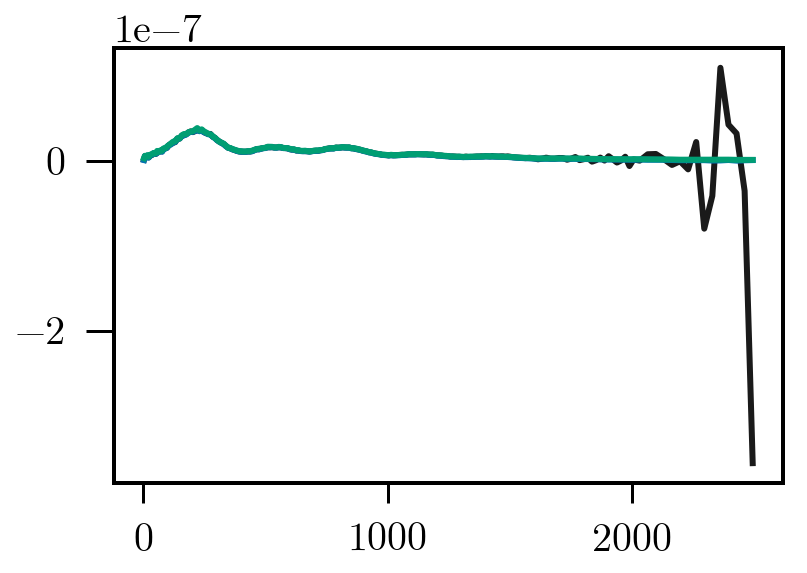

In [17]:
for r in res:
    plt.plot(r[0], r[1]*r[0]**2)

In [36]:
l, cl = res[-1]

In [37]:
lmin_,lmax_,l_ref,cl_ref,error_ref=np.loadtxt('planck_spectra/spectra_' + f'TT_{217}x{217}' + '.dat',unpack=True)
ref_fac = l_ref*(l_ref+1)/(2*np.pi)
dl_ref = cl_ref * ref_fac

dl = np.interp(x=l_ref, xp=l, fp=cl*1e12) * ref_fac

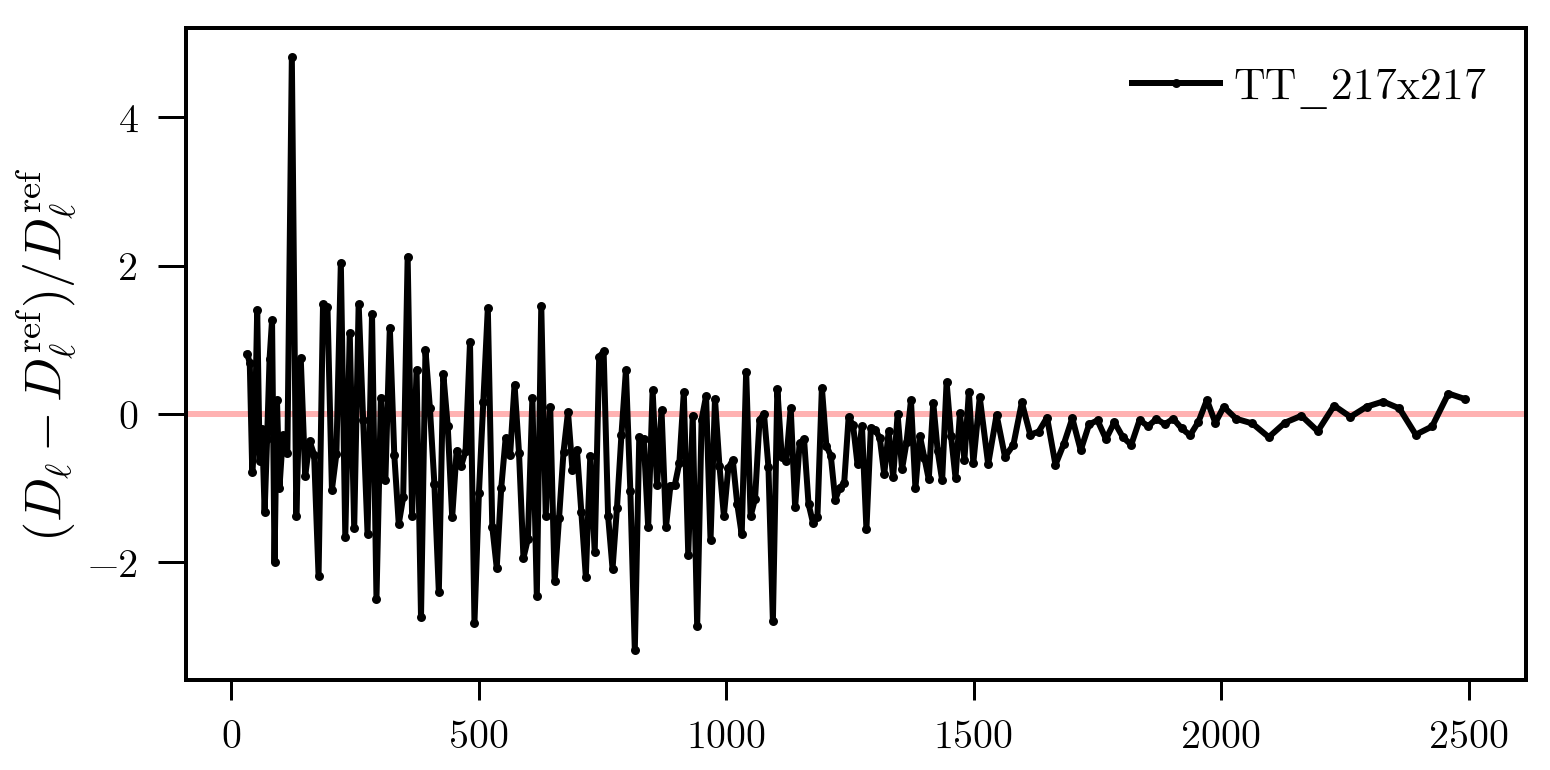

In [39]:
plt.figure(figsize=(12,6))
plt.axhline(0, color='red', alpha=0.3)
plt.plot( l_ref,(dl  - dl_ref) / (error_ref * ref_fac), 'k.-', label=f'TT_{217}x{217}')
plt.ylabel(r'$(D_{\ell} - D_{\ell}^{\mathrm{ref}}) / D_{\ell}^{\mathrm{ref}}$')
# plt.ylim(0.98,1.02)
plt.legend()